In [18]:
import tqix, constant, base
import numpy as np
import importlib
importlib.reload(constant)
importlib.reload(base)
n = 5
lambdax = 0.05
hs = [-0.1, 0, 0.1]

def H_LMG(h, lambdax, n, Jx, Jy, Jz):
    return -2*h*Jz - 2*lambdax/n*(Jx**2 - Jy**2)

# def get_psi(thetas, n):
#     qc = qiskit.QuantumCircuit(n)
#     for i in range(0, n, 3):
#         qc.rx(thetas[i], 0)
#         qc.rz(thetas[i + 1], 1)
#         qc.rx(thetas[i + 2], 2)
#     return qiskit.quantum_info.Statevector.from_instruction(qc).data

def cost_function(thetas):

    qc = tqix.circuit(n)
    for i in range(0, n):
        qc.RX(thetas[i], i)
        qc.RZ(thetas[i + n], i)
        qc.RX(thetas[i + 2 * n], i)
        
    Jx = qc.Jx()
    Jy = qc.Jy()
    Jz = qc.Jz()
    print("Jx: ", Jx.toarray())
    print("Jy: ", Jy.toarray())
    print("Jz: ", Jz.toarray())
    h_LMG = H_LMG(hs[0], lambdax, n, Jx, Jy, Jz)
    psi = qc.state
    return (np.trace((h_LMG @ psi).toarray()))

# costs = []
# thetas = np.ones(n*3)
# for i in range(0, 30):
#     thetas = thetas - constant.learning_rate*base.two_prx(cost_function, thetas)
#     print(base.two_prx(cost_function, thetas))
#     costs.append(cost_function(thetas))

In [19]:
cost_function(thetas)

Jx:  [[0.         1.11803399 0.         0.         0.         0.        ]
 [1.11803399 0.         1.41421356 0.         0.         0.        ]
 [0.         1.41421356 0.         1.5        0.         0.        ]
 [0.         0.         1.5        0.         1.41421356 0.        ]
 [0.         0.         0.         1.41421356 0.         1.11803399]
 [0.         0.         0.         0.         1.11803399 0.        ]]
Jy:  [[0.+0.j         0.-1.11803399j 0.+0.j         0.+0.j
  0.+0.j         0.+0.j        ]
 [0.+1.11803399j 0.+0.j         0.-1.41421356j 0.+0.j
  0.+0.j         0.+0.j        ]
 [0.+0.j         0.+1.41421356j 0.+0.j         0.-1.5j
  0.+0.j         0.+0.j        ]
 [0.+0.j         0.+0.j         0.+1.5j        0.+0.j
  0.-1.41421356j 0.+0.j        ]
 [0.+0.j         0.+0.j         0.+0.j         0.+1.41421356j
  0.+0.j         0.-1.11803399j]
 [0.+0.j         0.+0.j         0.+0.j         0.+0.j
  0.+1.11803399j 0.+0.j        ]]
Jz:  [[ 2.5  0.   0.   0.   0.   0. ]
 [ 0.

(-0.49979743540720084-2.1692513779182632e-17j)

In [15]:
np.min(costs)

(-0.49979743540720084-2.1692513779182632e-17j)

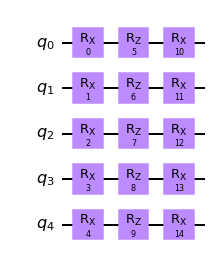

In [10]:
import qiskit
n = 5
thetas = np.zeros(3*n)
for i in range(0, thetas.shape[0]):
    thetas[i] += i
qc = qiskit.QuantumCircuit(n)
for i in range(0, n):
    qc.rx(thetas[i], i)
    qc.rz(thetas[i+n], i)
    qc.rx(thetas[i+2*n], i)
qc.draw('mpl')